In [1]:
import numba, os, sys, time, pickle, resource, copy
import astropy.units as u, matplotlib.pyplot as plt
import numpy as np, scipy.ndimage as ndimage
from sys import path

from numpy.random import Generator, PCG64

from sunpy.map import Map
from sunpy.net import Fido, attrs as a, vso
from sunpy.time import TimeRange
from astropy.coordinates import SkyCoord
import importlib

base_path = ".." # Replace this with the path you want CROBAR putting files.
path.append(os.path.join(base_path,'python_modules'))
from local_cartesian_transform import planar_map_coords, curved_map_coords, transform, transform_curved, wrld2pix
from loop_processing import filter_loops, resample_loops
from initial_points import volume_seed_points, fluxweighted_seed_points, region_seed_points, hilbert_seed_points
from label_loop_regions import label_loop_regions
from coord_grid import coord_grid
import forcefree_field
from util import estimate_aia_error, search_fido_response, bindown2, get_limb, get_limb_occlusion
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission

data_path = os.path.join(base_path,'example_data')
hmi_data_dir = data_path
aia_data_dir = data_path
crobar_output_dir = os.path.join(base_path,'save')
plot_dir = os.path.join(base_path,'plot')
rotation_directory = os.path.join(plot_dir,'rotation')

plt.rcParams.update({'font.size': 18,'figure.figsize':[10,6],'image.origin':'lower'})

In [2]:
length_unit = u.cm
date='2018/02/03 14:10:17'
datestr = date.replace('/','').replace(' ','_').replace(':','')

# Voxel size for CROBAR (0.42 Mm here)
dvox = np.array([(0.42*u.Mm).to(length_unit).value]*3)

# Voxel size for initial points:
flt_dvox = dvox*[1.0,1.0,10.0] # Initial point filtering voxel size
nloops_vol = 150 # Number of initial point randomly selected in the volume
nloops_flux = 4500 # Number of flux weighted initial points

# Value of force-free alpha to use for field line tracing:
alpha = 18.0/1.0e11   ############
alphastr = str(round(alpha/1.0e-11,3))

psf_size_px = 0.7 # Default PSF size in pixels
min_height = 1.0*dvox[2] # Loops must rise at least this high
min_length = 8.0*np.mean(dvox) # Loops must be at least this long

# Start tracing this high above the solar surface:
ivp_z0 = 0.02*dvox[2]
ivp_xpo = 1.0
ivp_clip = 0.99

download = True # Download from VSO.
newpoints = True # Generate new seed points.
newtrace = True # Retrace field lines.

# Save footpoints to this file
footpoint_savefile = os.path.join(crobar_output_dir,'footpoints_'+datestr+'.pickle')
# Save traced loops to this file:
loop_savefile = os.path.join(crobar_output_dir,'loops_'+datestr+'_'+alphastr+'.pickle')
# Save emission cube to this file:
em3d_savefile = os.path.join(crobar_output_dir,'em3d_'+datestr+'_'+alphastr+'.npy')

# X and y range of solar images to use for SDO/STEREO:
[x0, y0, xsz0, ysz0] = [-110, -200, 250, 300]
[xl, yl, xh, yh] = [x0, y0, x0+xsz0, y0+ysz0]

# Voxels are padded inward from the crop range by this much:
vox_boundpad = np.array([[0.05,0.05,0.001],[-0.05,-0.05,-0.1]])
# Initial points are padded inward from the crop range by this much:
ivp_boundpad = np.array([[0.05,0.05,0.075],[-0.05,-0.05,-0.7]])

scaltemp1 = 0.7e6 # Temperature for estimating scale height of loop profile 1
scaltemp2 = 0.7e6 # Temperature for estimating scale height of loop profile 2
chan1_xpo = 2.0 # Assumed exponential power law index of the temperature response function
zmin0 = 2.63e8 # Minimum height

psfmat=None # reset this variable for later...

In [3]:
# An arcsecond from one AU
asec_cm = 1.49e13/(3600*180/np.pi)
nloops0 = nloops_vol+nloops_flux
flux_factor = dvox[0]*dvox[1]
gfac = 1.0/2.2
length_unit = u.cm

# Massaging the x and y ranges:
# This is the nominal crop region
cropr0 = [x0, x0+xsz0, y0, y0+ysz0]*u.arcsec

# This is the crop region padded outward slightly,
# which provides the full dimensions of the reconstruction cube:
cropr = [x0-xsz0*(vox_boundpad[0,0]/(1-vox_boundpad[0,0])),x0+xsz0/(1+vox_boundpad[1,0]),
        y0-ysz0*(vox_boundpad[0,1]/(1-vox_boundpad[0,1])),y0+ysz0/(1+vox_boundpad[1,1])]*u.arcsec

# Crop the data for the reconstruction inward a bit compared to the cube. 
# This improves the ability of the reconstruction to fit the data, although 
# it does also mean that the edges of the reconstruction cube are underconstrained. 
cropr1 = cropr0+np.array([10,-10,10,-10])*u.arcsec

In [4]:
if(download):
	time_range = TimeRange(TimeRange(date,-10*u.s).start,TimeRange(date,10*u.s).end)
	qry_aia211 = Fido.search(a.Time(time_range),a.Instrument('AIA'),a.Wavelength(211*u.angstrom))
	aia211dat_path = Fido.fetch(qry_aia211[0][0],path=aia_data_dir)[0]
	
	time_range = TimeRange(TimeRange(date,-60*u.s).start,TimeRange(date,60*u.s).end)
	qry_hmi = Fido.search(a.Time(time_range),a.Instrument('HMI'),a.Physobs('LOS_magnetic_field'))
	magnetogram_path = Fido.fetch(qry_hmi[0][0],path=hmi_data_dir)[0]
else:
	# These filenames may be need to be updated if redownloaded or other data is used:
	aia211dat_path = os.path.join(aia_data_dir,'aia_lev1_211a_2018_02_03t14_10_09_63z_image_lev1.fits')
	magnetogram_path = os.path.join(hmi_data_dir,'hmi_m_45s_2018_02_03_14_10_30_tai_magnetogram.fits')

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_211a_2018_02_03t14_10_09_63z_image_lev1.fits:   0%|          | 0.00/9.37M [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

hmi_m_45s_2018_02_03_14_10_30_tai_magnetogram.fits:   0%|          | 0.00/16.6M [00:00<?, ?B/s]

In [5]:
print(aia211dat_path,magnetogram_path)

../example_data/aia_lev1_211a_2018_02_03t14_10_09_63z_image_lev1.fits ../example_data/hmi_m_45s_2018_02_03_14_10_30_tai_magnetogram.fits


In [6]:
# Load and crop the magnetogram:
magnetogram = Map(magnetogram_path)#.rotate(order=3)
blc=SkyCoord(cropr[0],cropr[2],frame=magnetogram.coordinate_frame)
trc=SkyCoord(cropr[1],cropr[3],frame=magnetogram.coordinate_frame)
magnetogram = magnetogram.submap(blc,top_right=trc)

# Get the 'local' coordinate system for the magnetogram. In this coordinate system,
# the radial axis at image center (not necessarily coordinate center due to solar
# curvature) is the z axis, and the x axis is aligned with solar longitude.
vox_lct = transform_curved(magnetogram.center)

# Compute the coordinates of the magnetogram pixels and the magnetic field strengths
# corrected for inclination by assuming that the surface fiels are radial. Points too far
# from disk center are masked out. This code will also attempt to correct the line-of-sight
# fields to radial by assuming the field lines on the photosphere are radial.
[mag, mag_coords, good_mask] = curved_map_coords(magnetogram,lct=vox_lct)
mag_coords = mag_coords.to(length_unit).value

rsun_cm = magnetogram.center.rsun.to(length_unit).value

In [7]:
# Set up boundaries for overall region:
bounds0 = np.array([[np.min(c),np.max(c)] for c in mag_coords]).T
bounds0[1,2] = bounds0[0,2] + 0.625*np.min(bounds0[1,0:2]-bounds0[0,0:2])

heights = (mag_coords[0]**2+mag_coords[1]**2+(rsun_cm+mag_coords[2])**2)**0.5 - rsun_cm

# Boundaries for field line tracing are set slightly larger to avoid
# issues when an initial point falls outside the boundary:
tracer_bounds = copy.deepcopy(bounds0)
tracer_bounds[0,0] -= 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[0,1] -= 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[1,0] += 0.001*(tracer_bounds[1,0]-tracer_bounds[0,0])
tracer_bounds[1,1] += 0.001*(tracer_bounds[1,1]-tracer_bounds[0,1])
tracer_bounds[0,2] = np.max(heights)
tracer_bounds[1,2] = tracer_bounds[0,2] + bounds0[1,2]-bounds0[0,2] # np.max(mag_coords[2,:,:,:]) - bounds0[0,2]

# Get coordinate grids (see coord_grid.py for details of these)
def bounds2grid(bounds0,dvox,offsets=None,pad=None,frame=None):
    if(offsets is None): offsets = 0.5+0.0*dvox
    if(pad is None): pad = np.zeros([2,len(dvox)])
    if(frame is None): frame = np.arange(len(dvox))
    bounds = bounds0+pad*(bounds0[1]-bounds0[0])
    nvox = np.floor((bounds[1]-bounds[0])/dvox).astype(np.int32)
    vox_origin = bounds[0]+offsets*(bounds[1]-bounds[0]-nvox*dvox)
    return coord_grid(nvox,vox_origin,np.diag(dvox),frame)

# This is the grid for the voxels:
vox_grid = bounds2grid(bounds0,dvox,offsets=[0.5,0.5,0.0],pad=vox_boundpad)
# This is the grid used for generating initial points and filtering them:
flt_grid = bounds2grid(bounds0,flt_dvox,offsets=[0.5,0.5,0.0])

In [8]:
# Field values and coordinates used for tracing the magnetogram 
# (commented out code will bin it down by a factor of 2, but largely not needed with the MDI 
# magnetogram used in this example):
mag_trace = bindown2(mag[:,:,0],2)/4
mag_coords_trace = np.array([bindown2(xa[:,:,0],2)/4 for xa in mag_coords])

In [9]:
if(newpoints):
    ivp_bounds = tracer_bounds+ivp_boundpad*(tracer_bounds[1]-tracer_bounds[0])
    volume_initial_points = volume_seed_points(nloops_vol, ivp_bounds)
    #fluxw_initial_points = fluxweighted_seed_points2(nloops_flux, mag, mag_coords, ivp_bounds, z0=ivp_z0, xpo=ivp_xpo, clip=ivp_clip)
    fluxw_initial_points = hilbert_seed_points(nloops_flux, mag, mag_coords, ivp_z0, rsun=rsun_cm)
    initialpoint_dict = {'xydomain':[x0,y0,xsz0,ysz0], 'vox_boundpad':vox_boundpad, 'ivp_boundpad':ivp_boundpad, 
                         'dvox':dvox, 'min_height':min_height, 'min_length':min_length, 'magnetogram_path':magnetogram_path, 
                         'date':date, 'datestr':datestr, 'magnetogram':magnetogram, 'mag':mag, 'mag_coords':mag_coords,
                         'ivp_bounds':ivp_bounds, 'ivp_z0':ivp_z0, 'ivp_xpo':ivp_xpo, 'ivp_clip':ivp_clip, 'cropr':cropr,
                         'cropr0':cropr0, 'vox_grid':vox_grid, 'volume_initial_points':volume_initial_points, 
                         'fluxw_initial_points':fluxw_initial_points, 'flt_grid':flt_grid}

    filehandler = open(footpoint_savefile,"wb")
    pickle.dump(initialpoint_dict,filehandler)
    filehandler.close()
if(not(newpoints)):
    file = open(footpoint_savefile,'rb')
    initialpoint_dict = pickle.load(file)
    file.close()
    fluxw_initial_points = initialpoint_dict['fluxw_initial_points']
    volume_initial_points = initialpoint_dict['volume_initial_points']
    ivp_bounds = initialpoint_dict['ivp_bounds']
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [10]:
# Plot the initial points over the magnetogram:
fluxw_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in fluxw_initial_points]
volume_initial_pt_pix = [wrld2pix(vox_lct.coord(pts*u.cm),magnetogram,magnetogram,vox_lct=vox_lct) for pts in volume_initial_points]

fluxw_initial_pt_pix = np.vstack(fluxw_initial_pt_pix)
volume_initial_pt_pix = np.vstack(volume_initial_pt_pix)

(0.0, 660.0)

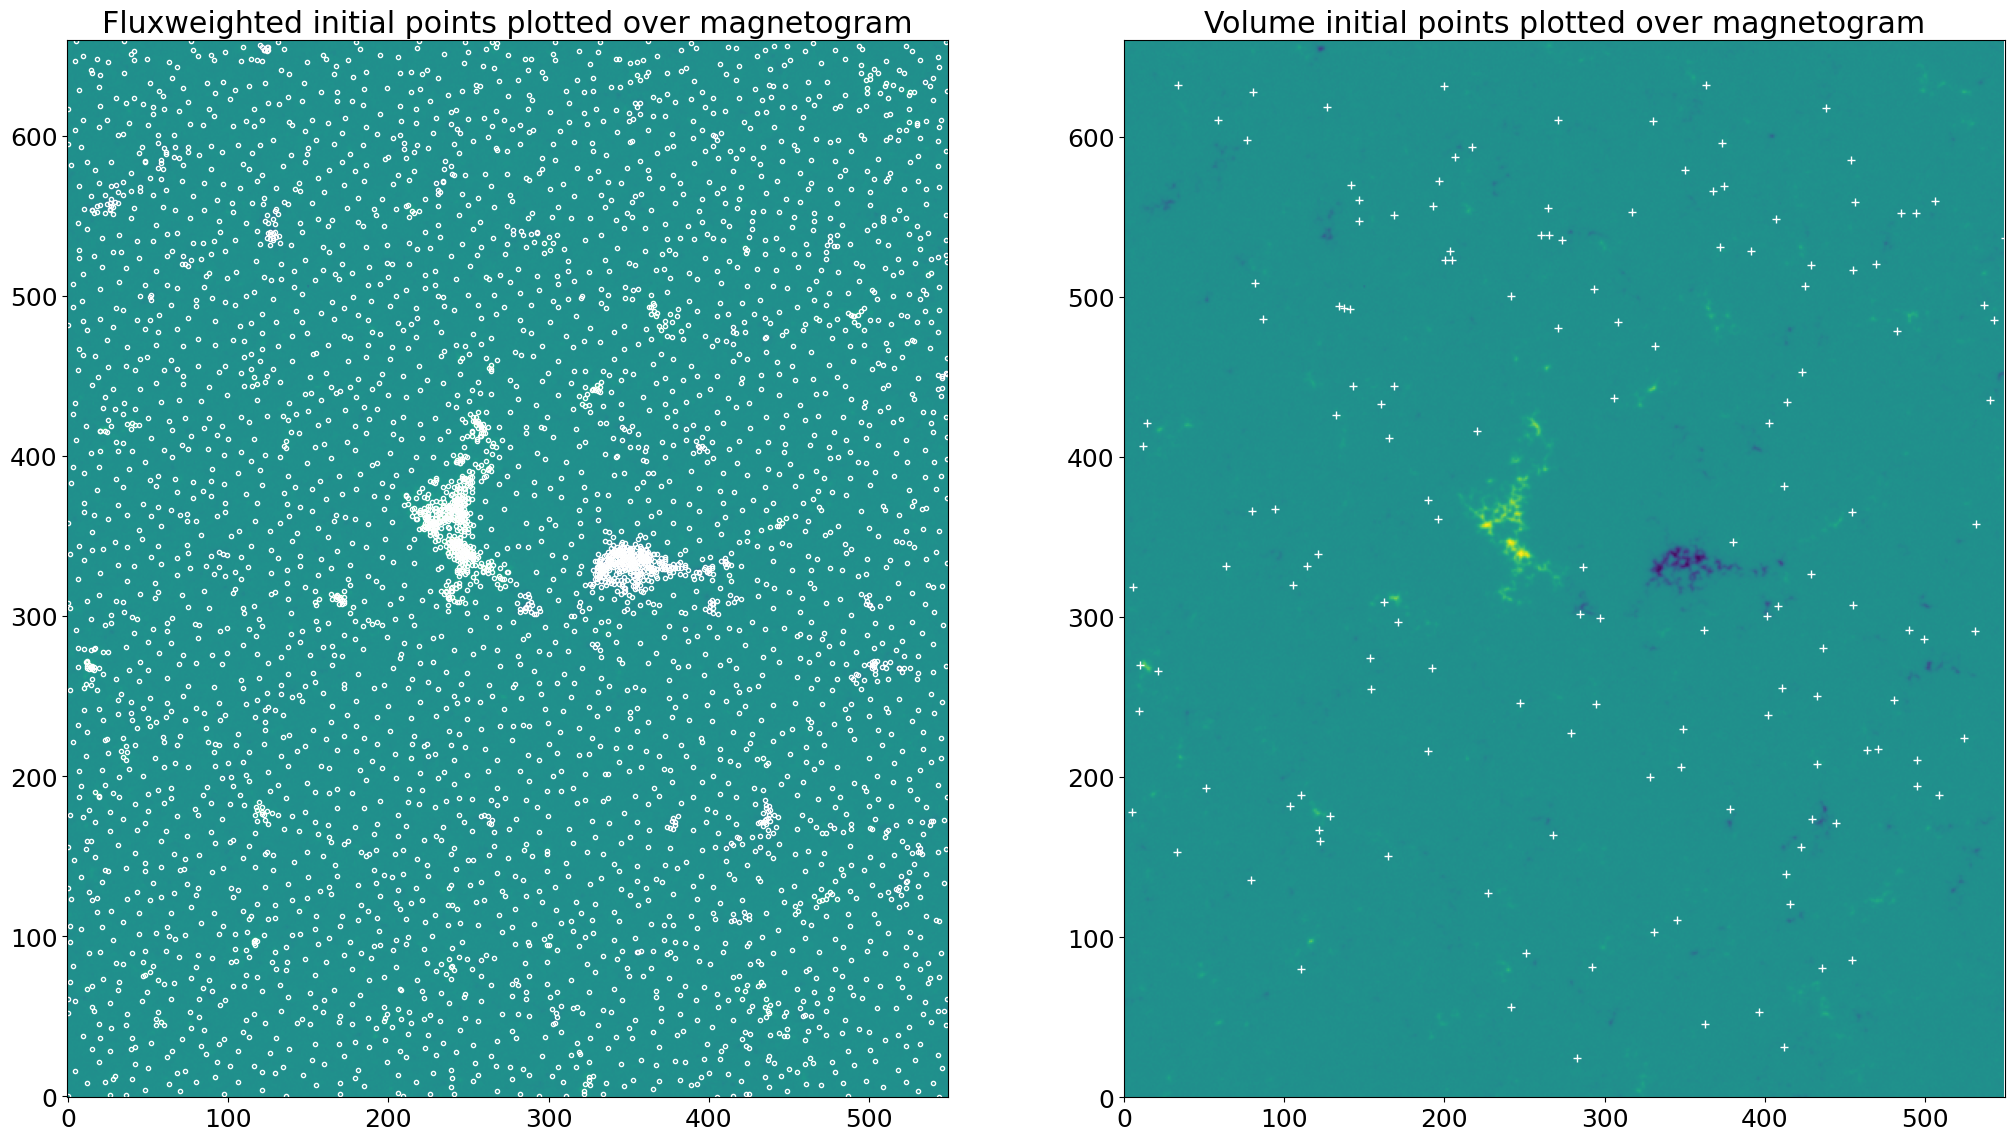

In [11]:
fig = plt.figure(figsize=[25,30])
extent = np.array([bounds0[0,0],bounds0[1,0],bounds0[0,1],bounds0[1,1]])/1.0e8

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax1.plot(fluxw_initial_pt_pix[:,1],fluxw_initial_pt_pix[:,0],'.',color='white', markerfacecolor='none')
ax1.set(title='Fluxweighted initial points plotted over magnetogram')

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(mag[:,:,0],origin='lower',vmin=-1000,vmax=1000)
ax2.plot(volume_initial_pt_pix[:,1],volume_initial_pt_pix[:,0],'+',color='white')
ax2.set(title='Volume initial points plotted over magnetogram')
plt.xlim(0,mag.shape[1])
plt.ylim(0,mag.shape[0])

In [12]:
use_points = np.vstack((volume_initial_points,fluxw_initial_points))

In [13]:
# Trace field lines if newtrace is true:
if(newtrace):
    fieldlines = forcefree_field.tracer(use_points, mag_trace, mag_coords_trace, bounds=tracer_bounds, alpha=alpha, rtol=1.0e-5,atol=0.001*dvox[0], boundrad=magnetogram.center.rsun.to(u.cm).value)
    filehandler = open(loop_savefile,"wb")
    pickle.dump(fieldlines,filehandler)
    filehandler.close()
# Otherwise reload from the previously specified file:
if(newtrace==0):
    file = open(loop_savefile,'rb')
    fieldlines = pickle.load(file)
    file.close()

Done with line  49  at  20.046340227127075  s
Done with line  99  at  44.35579538345337  s
Done with line  149  at  57.43257737159729  s
Done with line  199  at  62.400503396987915  s
Done with line  249  at  69.28331470489502  s
Done with line  299  at  84.73807382583618  s
Done with line  349  at  108.23225903511047  s
Done with line  399  at  116.89636445045471  s
Done with line  449  at  123.04927515983582  s
Done with line  499  at  131.31007742881775  s
Done with line  549  at  136.5291392803192  s
Done with line  599  at  140.83746099472046  s
Done with line  649  at  146.71290111541748  s
Done with line  699  at  151.81695103645325  s
Done with line  749  at  157.43986582756042  s
Done with line  799  at  165.0785002708435  s
Done with line  849  at  170.19043850898743  s
Done with line  899  at  176.52321553230286  s
Done with line  949  at  182.79726576805115  s
Done with line  999  at  187.68918228149414  s
Done with line  1049  at  192.99026942253113  s
Done with line  1099

In [14]:
# Resample loops so that they're regularly spaced, and footpoints are at the photosphere (open ends exempted):
[fieldlines_resamp,lengths] = resample_loops(fieldlines[0],tracer_bounds,0.1*np.mean(dvox),rcurv=rsun_cm)
# Filter out loops whose footpoints fall too close together:
[fieldlines_filter,lengths_filter] = filter_loops(fieldlines_resamp, lengths, flt_grid, lmin=min_length, zmin = min_height, rcurv=rsun_cm)
nloops = len(fieldlines_filter)
print(nloops0,nloops)

1.14422607421875 1.1442108154296875 102 103 1 103
1.14422607421875 1.1442108154296875 95 97 1 97
1.14422607421875 1.1442108154296875 77 78 1 78
1.14422607421875 1.1442108154296875 101 102 1 102
1.14422607421875 1.1442108154296875 69 71 1 71
1.14422607421875 1.14422607421875 52 52 1 52
1.14422607421875 1.14422607421875 79 79 1 79
1.14422607421875 1.1442108154296875 80 81 1 81
1.14422607421875 1.14422607421875 65 64 1 65
1.14422607421875 1.1442108154296875 58 59 1 59
1.14422607421875 1.1442108154296875 73 74 1 74
1.14422607421875 1.1442108154296875 119 120 1 120
1.14422607421875 1.1442108154296875 74 76 1 76
1.14422607421875 1.1442108154296875 65 66 1 66
1.14422607421875 1.14422607421875 76 76 1 76
1.14422607421875 1.1442108154296875 78 79 1 79
1.14422607421875 1.14422607421875 53 52 1 53
1.14422607421875 1.1442108154296875 58 58 1 59
1.14422607421875 1.14422607421875 68 68 1 68
1.14422607421875 1.1442108154296875 83 84 1 84
1.14422607421875 1.1442108154296875 76 77 1 77
1.14422607421875

In [15]:
# Create core voxel cube identifying every voxel with a loop:
[loopids, loopid_info, voxel_loop_lengths] = label_loop_regions(fieldlines_filter, lengths_filter, vox_grid)

Total number of loop points =  318028
Memory usage:  709932  kb
Computing Voronoi cells:
Done computing Voronoi cells, elapsed time= 27.324758768081665
Memory usage: 5403876 (kb)
Memory usage:  5404004  kb
Number of Chunks:  90
Checked chunk 3 , elapsed time: 3.992401361465454 s, Memory usage: 5404004 kb
Checked chunk 7 , elapsed time: 10.93629240989685 s, Memory usage: 5404004 kb
Checked chunk 11 , elapsed time: 16.509254932403564 s, Memory usage: 5404004 kb
Checked chunk 15 , elapsed time: 22.19203019142151 s, Memory usage: 5404004 kb
Checked chunk 19 , elapsed time: 27.99255633354187 s, Memory usage: 5404004 kb
Checked chunk 23 , elapsed time: 34.19548439979553 s, Memory usage: 5404004 kb
Checked chunk 27 , elapsed time: 42.407145738601685 s, Memory usage: 5404004 kb
Checked chunk 31 , elapsed time: 53.58612585067749 s, Memory usage: 5404004 kb
Checked chunk 35 , elapsed time: 56.42094850540161 s, Memory usage: 5404004 kb
Checked chunk 39 , elapsed time: 60.7518630027771 s, Memory u

In [16]:
# Produce a mask cube which is used to zero out points in the 
# cube that are beneath the solar surface:
limb_mask = get_limb(vox_grid,rsun_cm)

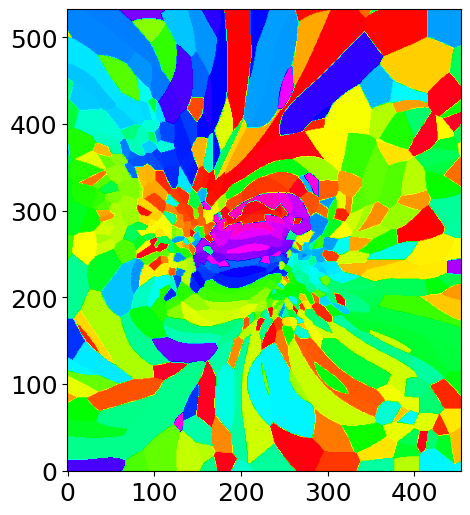

In [17]:
# This is a slice of the voxel label cube at a particular height with the limb mask applied,
# showing each loop as a different color
indx = 75
plt.imshow((limb_mask[:,:,indx]*loopids[:,:,indx] % 200).T, origin='lower',cmap=plt.get_cmap('gist_rainbow'))

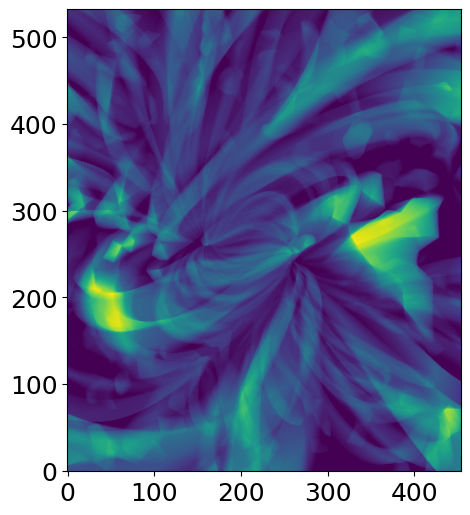

In [18]:
# This is a sum through the cube with every 5th loop illuminated:
plt.imshow(np.sum(limb_mask*(loopids % 5 == 0),axis=2).T)

In [19]:
import reconstruct_2comp_3Dloops
importlib.reload(reconstruct_2comp_3Dloops)
from reconstruct_2comp_3Dloops import reconstruct, compute_fwdmat, get_3d_emission


# Compute the forward matrix from the field-aligned regions to the data:
[amat,modelinputs] = compute_fwdmat(aia211dat_path, None, loopids, loopid_info,
                                    vox_grid, cropr1, magnetogram, voxel_loop_lengths, curvature=False, 
                                    vox_mask=limb_mask, xpo1 = chan1_xpo, xpo2 = chan1_xpo, temp1=scaltemp1, 
                                    psf_size_px=0.4, zmin=np.min(mag_coords[2]), temp2=scaltemp2, asym=True)

../example_data/aia_lev1_211a_2018_02_03t14_10_09_63z_image_lev1.fits None 700000.0 700000.0 2.0 2.0 None None 6000.0 500.0 None -1747156785.286677 3 None 0.4 True False None None None None None None None None None 0.3333333333333333 1.0
Memory usage: 5404004 (kb)
Memory usage: 5404004 (kb)
Slice  0  of  283 0.02524256706237793 Using: 5404004 kb
Slice  1  of  283 0.04995131492614746 Using: 5404004 kb
Slice  2  of  283 0.07393407821655273 Using: 5404004 kb
Slice  3  of  283 0.0985863208770752 Using: 5404004 kb
Slice  4  of  283 0.12302160263061523 Using: 5404004 kb
Slice  5  of  283 0.14766335487365723 Using: 5404004 kb
Slice  6  of  283 0.17162466049194336 Using: 5404004 kb
Slice  7  of  283 0.19633793830871582 Using: 5404004 kb
Slice  8  of  283 0.2207944393157959 Using: 5404004 kb
Slice  9  of  283 0.24529647827148438 Using: 5404004 kb
Slice  10  of  283 0.2697439193725586 Using: 5404004 kb
Slice  11  of  283 0.2940516471862793 Using: 5404004 kb
Slice  12  of  283 0.318479061126709 U

In [20]:
# Error estimates for the reconstruction:
chan1_err = estimate_aia_error(modelinputs['map'], channel = 'AIA'+modelinputs['map'].meta['wave_str'])
# Reconstruct using the forward matrix:
solution = reconstruct(amat, modelinputs, reg_fac=0.15, dat_xpo=1, errs=chan1_err, solver_tol=1.0e-5)

4.4061320906209795 36.41208590564402 1400.0
Overall regularization factor: 1.369625526206221e-05
7063.205836984179 7063.205836984179 8.862654311980759 8.862654311980759
2.29 s i = 0 chi2 = 97.34 step size = 0.15 reg. param. = 0.38 chi2 change = 37.33784 reg. change = 0.00644
0 8.840483477596791 0.2518580072737538 8.174752286415185 11.792953393055157
7063.205836984179 7063.205836984179 8.174752286415185 11.792953393055157
4.29 s i = 1 chi2 = 34.5 step size = 0.67 reg. param. = 0.78 chi2 change = 62.8345 reg. change = -0.39797
1 8.556507096701251 0.8495515666289468 4.250399929261006 11.892576099418951
7063.205836984179 7063.205836984179 4.250399929261006 11.892576099418951
5.96 s i = 2 chi2 = 7.35 step size = 0.85 reg. param. = 0.62 chi2 change = 27.15497 reg. change = 0.15626
2 8.009501386997126 1.2829998802982268 0.359462783529362 11.959205688741301
7063.205836984179 7063.205836984179 0.359462783529362 11.959205688741301
7.7 s i = 3 chi2 = 2.43 step size = 0.85 reg. param. = 0.58 chi2 

In [21]:
# The product of the field-aligned region solution vector and the forward matrix is the reconstruction's estimate
# of the AIA image. amat and the solution use a scaled version of the matrix which greatly improves convergence of 
# Krylov methods, hence the loop_weights factors. For a single forward matrix rescaling by the loop weights below
# isn't necessary, but for multiple forward matrices (e.g., multiple perspectives) it is:
soln = copy.deepcopy(solution[0])/modelinputs['loop_weights']
aia_only_recon_dat_aia = (amat.T.dot(modelinputs['loop_weights']*soln)).reshape(modelinputs['map'].data.shape)

[Text(0.5, 1.0, 'Reconstruction of original AIA image')]

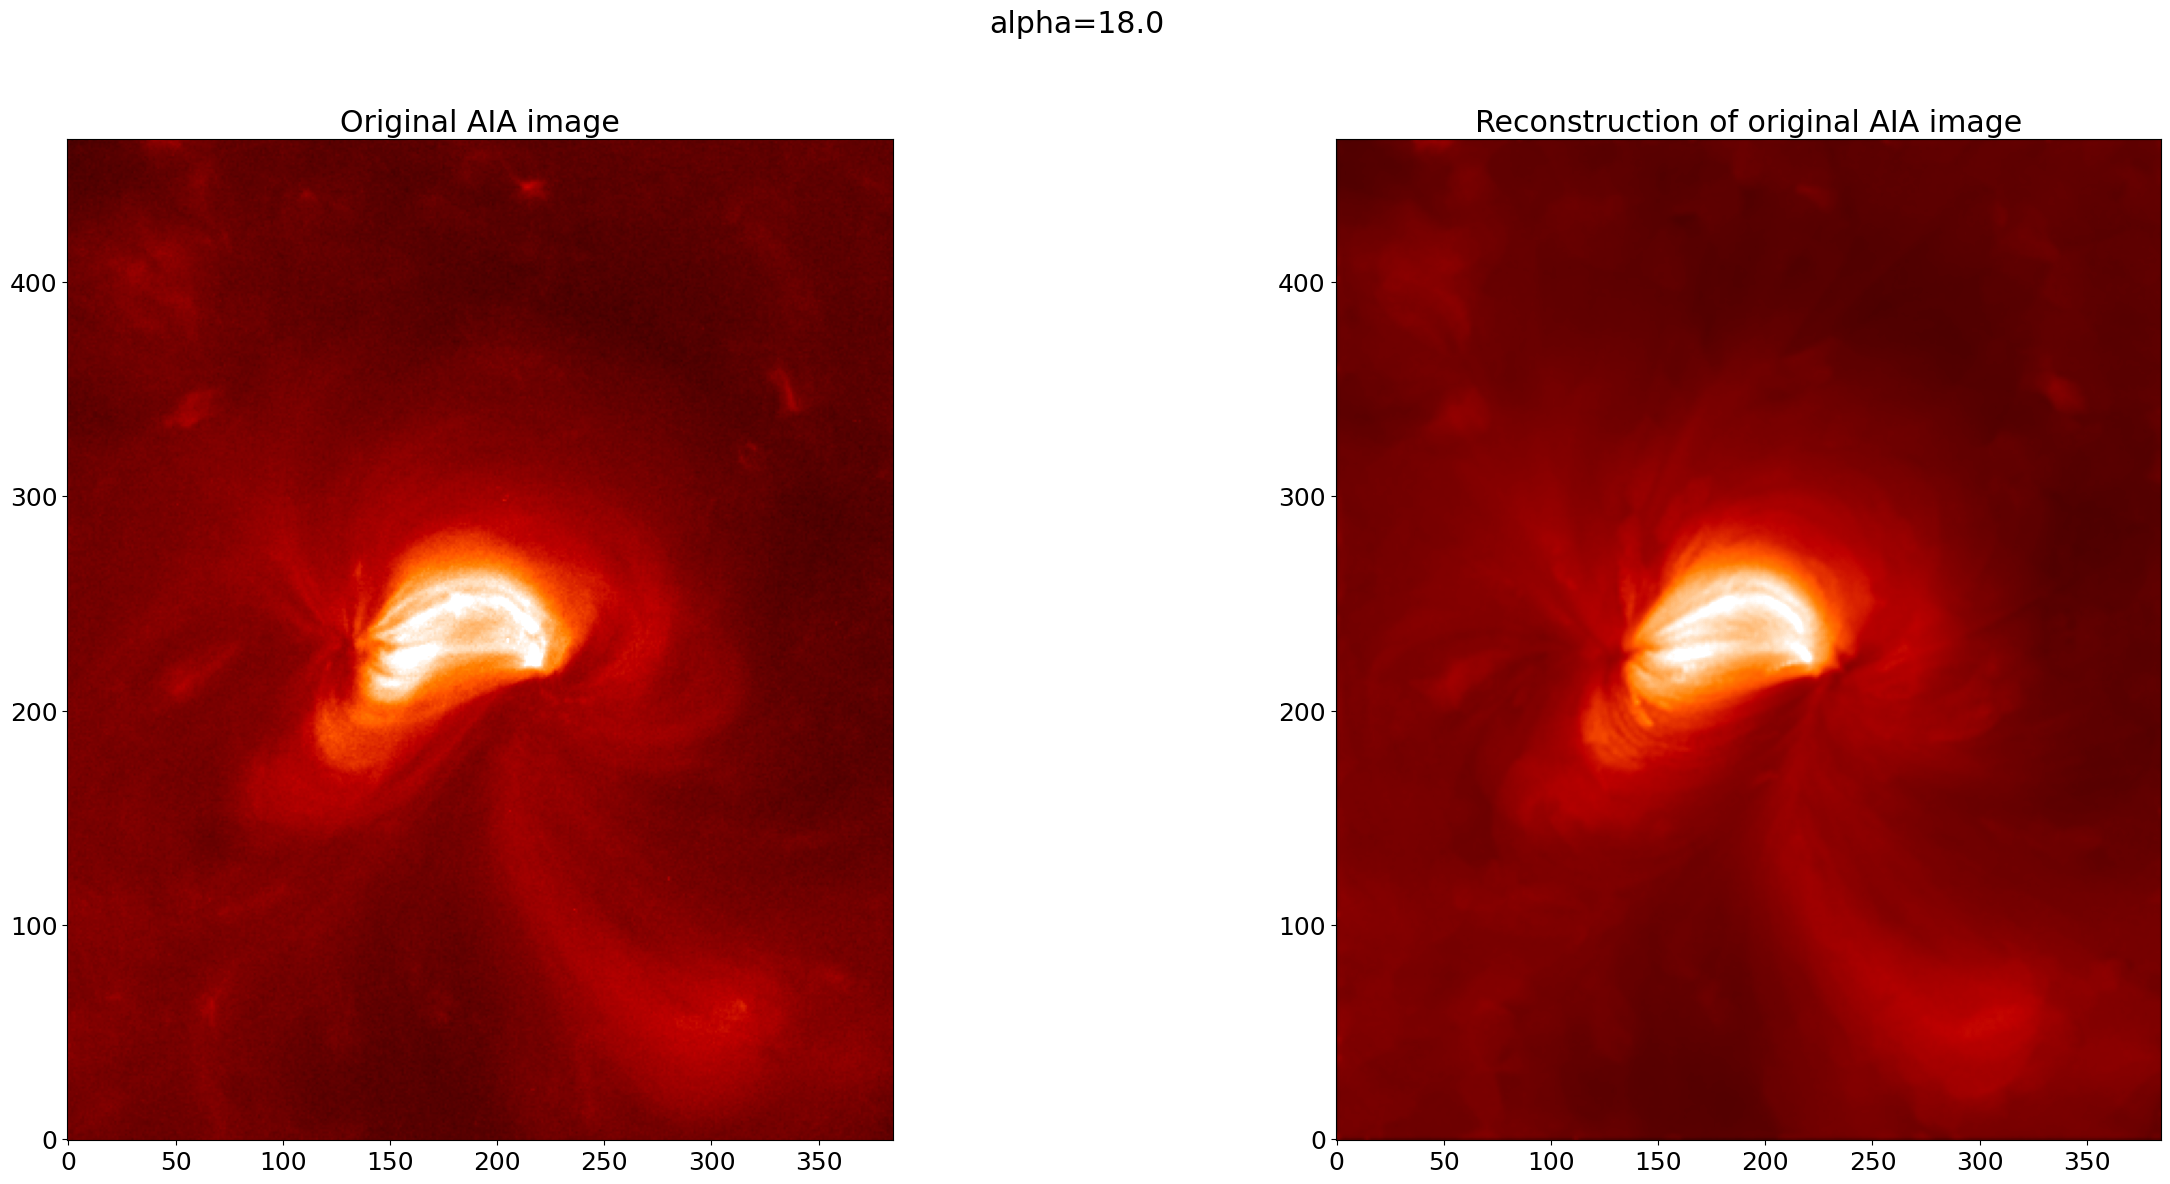

In [22]:
pltmax = 1000

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=[30,13])
plt.suptitle('alpha='+alphastr)
axes[0].imshow(np.abs(modelinputs['map'].data)**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[0].set(title='Original AIA image')
axes[1].imshow(aia_only_recon_dat_aia**gfac,cmap=plt.get_cmap('gist_heat'),vmin=0,vmax=pltmax**gfac)
axes[1].set(title='Reconstruction of original AIA image')

In [23]:
# Expand the solution into a 3D emission cube: 
em3d = get_3d_emission(solution[0], modelinputs, vox_grid, loopids, voxel_loop_lengths, loopid_info, zmin=np.min(mag_coords[2]))

Memory usage: 5404004 (kb)
0 283 -1747156785.286677 11928000000.0


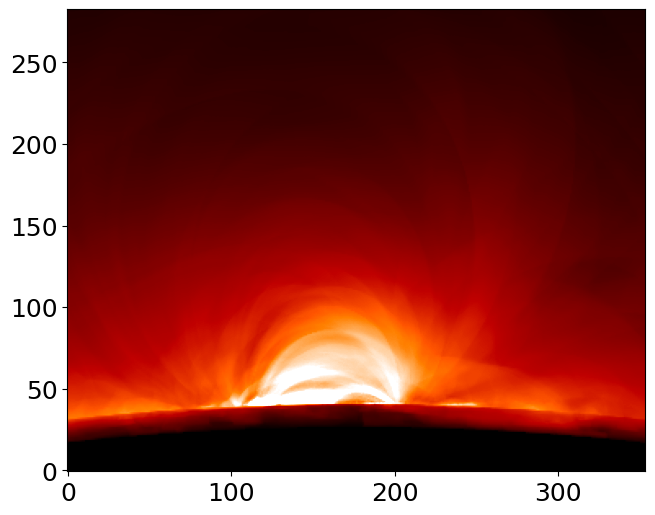

In [24]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from the pole):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=1).T**gfac,vmin=0,vmax=3.0e-5**gfac,cmap=plt.get_cmap('gist_heat'))

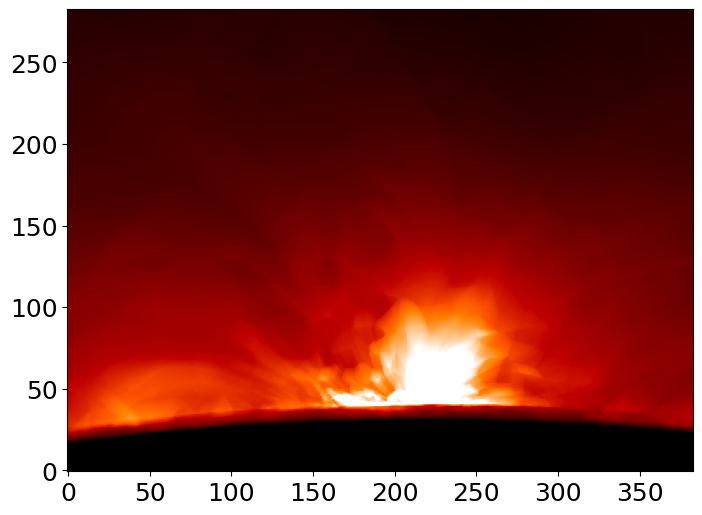

In [25]:
# Plot the x-z projection through the cube (e.g., as viewed on limb from ecliptic latitude):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=0).T**gfac,vmin=0,vmax=3.0e-5**gfac,cmap=plt.get_cmap('gist_heat'))

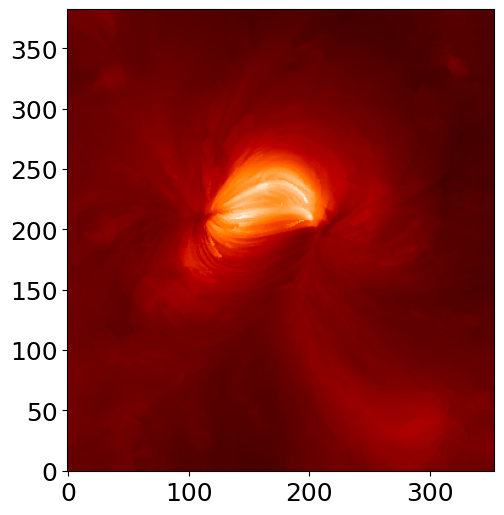

In [26]:
# Plot the x-y projection through the cube (e.g., as viewed from directly overhead):
plt.imshow(np.sum(limb_mask[50:-50,50:-100,:]*em3d[50:-50,50:-100,:],axis=2).T**gfac,vmin=0,vmax=3.0e-5**gfac,cmap=plt.get_cmap('gist_heat'))

In [27]:
# Save the reconstructed 3D emission cube:
em3d_out = em3d[50:-50,50:-50,:]*limb_mask[50:-50,50:-50,:]
em3d_norm = np.max(em3d_out)
print(em3d_norm*dvox[2])
mask_out = limb_mask[50:-50,50:-50,:]
em3d_out = (254*(em3d_out/np.max(em3d_out))**0.5).astype(np.uint8)
em3d_out[mask_out==False] = 255
np.save(em3d_savefile, em3d_out, allow_pickle=False) 

379.0421524172416


In [28]:
output_mask = np.zeros(em3d.shape,dtype=bool)
output_mask[50:-50,50:-50,:] = True

phi = 90

from project2frame import project

lon = modelinputs['map'].center.observer.lon
lat = modelinputs['map'].center.observer.lat
rad = modelinputs['map'].center.observer.radius

from local_cartesian_transform import transform, vox2pix, wrld2pix

In [29]:
# Plot a 3D rotation through the cube:
for i in range(00,361):
	# Pixel locations of the cropped reconstruction region (approximate):
	jl,jh,il,ih = np.round(np.array(cropr1.value)/0.6).astype(np.int32)+2048
	
	phi=i
	projection,psfmat = project(output_mask*em3d*limb_mask*dvox[2], loopid_info, initialpoint_dict, lat=lat, lon=lon+phi*u.deg, rad=rad, 
				   tim = modelinputs['map'].date, nx=4096, ny=4096, dx=0.6, dy=0.6, rota=0.0,
				   xrefpx=2048, yrefpx=2048, xrefcrd=0.0, yrefcrd=0.0, psfmat=psfmat)
	
	# Find the pixel location for the center voxel for the initial image:
	if(i == 0): cenpx0 = vox2pix([0.5,0.5,0.5]*loopid_info['nvox'], loopid_info['voxmin'], loopid_info['dvox'], 
								 magnetogram, projection, obswcs=projection.wcs,
								 voxcenter=magnetogram.center, vox_lct=vox_lct)

	# Find the pixel location for the center voxel for the current image:
	cenpx = vox2pix([0.5,0.5,0.5]*loopid_info['nvox'], loopid_info['voxmin'], loopid_info['dvox'], 
								 magnetogram, projection, obswcs=projection.wcs,
								 voxcenter=magnetogram.center, vox_lct=vox_lct)

	# Find the pixel offsets of the current image compared to the initial one and apply them.
	yoff, xoff = cenpx0[0]-cenpx[0], cenpx0[1]-cenpx[1]
	jl -= np.round(xoff).astype(np.int32)
	jh -= np.round(xoff).astype(np.int32)
	il -= np.round(yoff).astype(np.int32)
	ih -= np.round(yoff).astype(np.int32)
	
	extent = (np.array([jl,jh,il,ih])-2048)*0.6
	fig = plt.figure(figsize=[11,11]) #fig,axes = plt.subplots(nrows=1,ncols=1,figsize=[12,12])
	plt.imshow(projection.data[il:ih,jl:jh]**0.5,vmin=0,vmax=1400**0.5,extent=extent)
	plt.title(r' AIA 211 reconstruction at '+date+', rotated '+str(360-phi)+r'$^\circ$')
	plt.xlabel('Rotated Helioprojective Longitude (Solar-X, arcseconds)')
	plt.ylabel('Helioprojective Latitude (Solar-Y, arcseconds)')
	fig.tight_layout()
	plt.savefig(os.path.join(rotation_directory,'AIA211_rot'+str(360-phi).zfill(3)+'deg.png'))
	print('Finished '+str(360-phi)+' degrees')
	plt.close()

Finished 360 degrees
Finished 359 degrees
Finished 358 degrees
Finished 357 degrees
Finished 356 degrees
Finished 355 degrees
Finished 354 degrees
Finished 353 degrees
Finished 352 degrees
Finished 351 degrees
Finished 350 degrees
Finished 349 degrees
Finished 348 degrees
Finished 347 degrees
Finished 346 degrees
Finished 345 degrees
Finished 344 degrees
Finished 343 degrees
Finished 342 degrees
Finished 341 degrees
Finished 340 degrees
Finished 339 degrees
Finished 338 degrees
Finished 337 degrees
Finished 336 degrees
Finished 335 degrees
Finished 334 degrees
Finished 333 degrees
Finished 332 degrees
Finished 331 degrees
Finished 330 degrees
Finished 329 degrees
Finished 328 degrees
Finished 327 degrees
Finished 326 degrees
Finished 325 degrees
Finished 324 degrees
Finished 323 degrees
Finished 322 degrees
Finished 321 degrees
Finished 320 degrees
Finished 319 degrees
Finished 318 degrees
Finished 317 degrees
Finished 316 degrees
Finished 315 degrees
Finished 314 degrees
Finished 313 

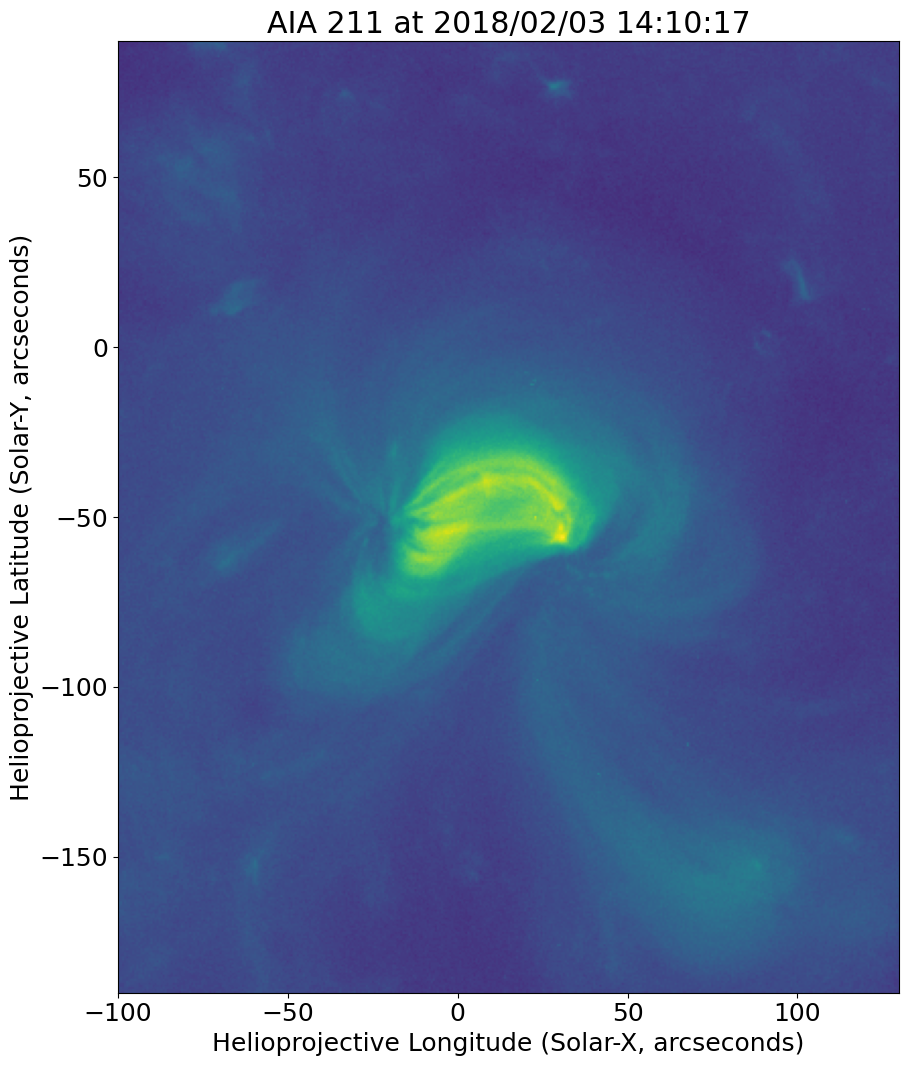

In [30]:
# Make a plot of the initial image for reference:
fig = plt.figure(figsize=[11,11])
plt.imshow(modelinputs['map'].data**0.5, vmin=0,vmax=1400**0.5, extent = cropr1.value)
plt.title(r'AIA 211 at '+date)
plt.xlabel('Helioprojective Longitude (Solar-X, arcseconds)')
plt.ylabel('Helioprojective Latitude (Solar-Y, arcseconds)')
fig.tight_layout()
plt.savefig(os.path.join(rotation_directory,'AIA211_orig.png'))